# Exploring Effect of Image Resizizing on Classification of CIFAR-10 dataset

### 

### load imports

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import time
import seaborn as sn
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [39]:

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
pre_trained_model_normalization = transforms.Normalize(mean=mean, std=std)

def loader_with_resize(size=32):

  validation_size = 0.5

  agugment = transforms.Compose([transforms.RandomRotation(30),
                                  transforms.RandomResizedCrop(size),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  pre_trained_model_normalization])

  no_augment = transforms.Compose([transforms.Resize(size),
                                    transforms.CenterCrop(size),
                                    transforms.ToTensor(),
                                    pre_trained_model_normalization])

  dataset = {
    'train': torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=agugment),
    'test' : torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=no_augment),
  }

  num_test = len(dataset['test'])
  indices = list(range(num_test))
  np.random.shuffle(indices)
  split = int(np.floor(validation_size * num_test))
  test_idxs, valid_idxs = indices[split:], indices[:split]

  test_sampler = SubsetRandomSampler(test_idxs)
  valid_sampler = SubsetRandomSampler(valid_idxs)


  loader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'valid': torch.utils.data.DataLoader(dataset['test'], batch_size=64, sampler=valid_sampler),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, sampler=test_sampler),
  }

  label_mapping = dataset['train'].classes
  return loader, label_mapping


### Inspect the dataset

In [40]:
def show4(dataloader, label_mapping):
    dataiter = iter(dataloader)
    fig, ax = plt.subplots(figsize=(12, 10), ncols=4)

    batch = next(dataiter)
    labels = batch[1][0:4]
    images = batch[0][0:4]
    for i in range(4):
        title = label_mapping[labels[i].item()]
        print(f'Class: {title}, Shape: {images[i].shape}')
    
        image = images[i].numpy().T
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax[i].set_title(title)
        ax[i].imshow(image)
    plt.show()

In [41]:
loader_32, label_mapping = loader_with_resize(32)
loader_64, label_mapping = loader_with_resize(64)
loader_128, label_mapping = loader_with_resize(128)
loader_256, label_mapping = loader_with_resize(256)

print(len(label_mapping), 'classes in this dataset')
print(label_mapping)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
10 classes in this dataset
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Class: frog, Shape: torch.Size([3, 32, 32])
Class: cat, Shape: torch.Size([3, 32, 32])
Class: bird, Shape: torch.Size([3, 32, 32])
Class: horse, Shape: torch.Size([3, 32, 32])


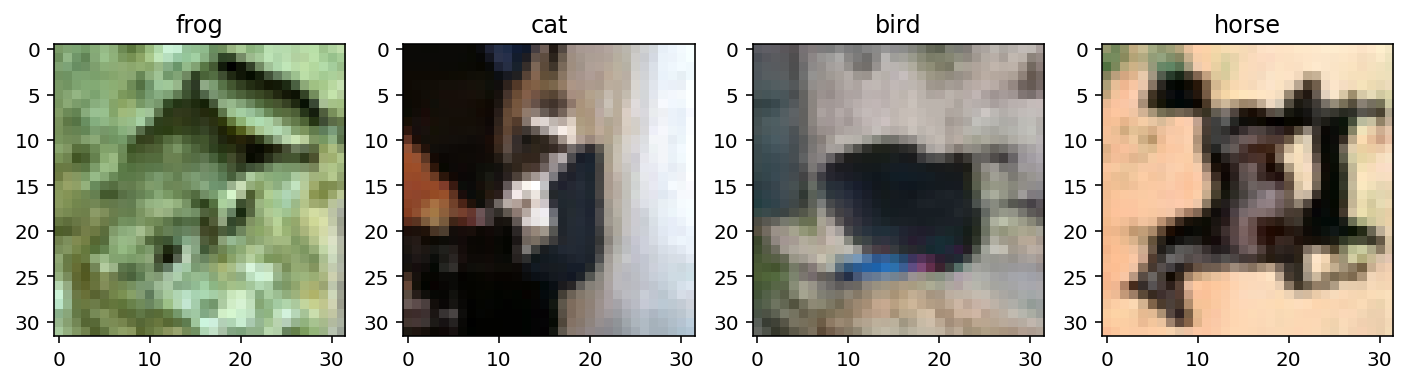

Class: truck, Shape: torch.Size([3, 64, 64])
Class: truck, Shape: torch.Size([3, 64, 64])
Class: deer, Shape: torch.Size([3, 64, 64])
Class: truck, Shape: torch.Size([3, 64, 64])


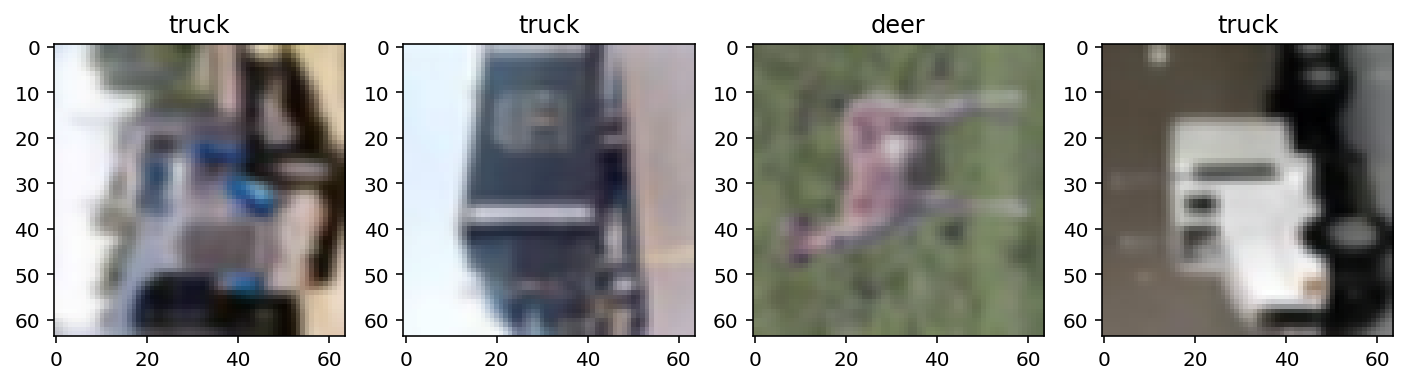

Class: frog, Shape: torch.Size([3, 128, 128])
Class: dog, Shape: torch.Size([3, 128, 128])
Class: airplane, Shape: torch.Size([3, 128, 128])
Class: deer, Shape: torch.Size([3, 128, 128])


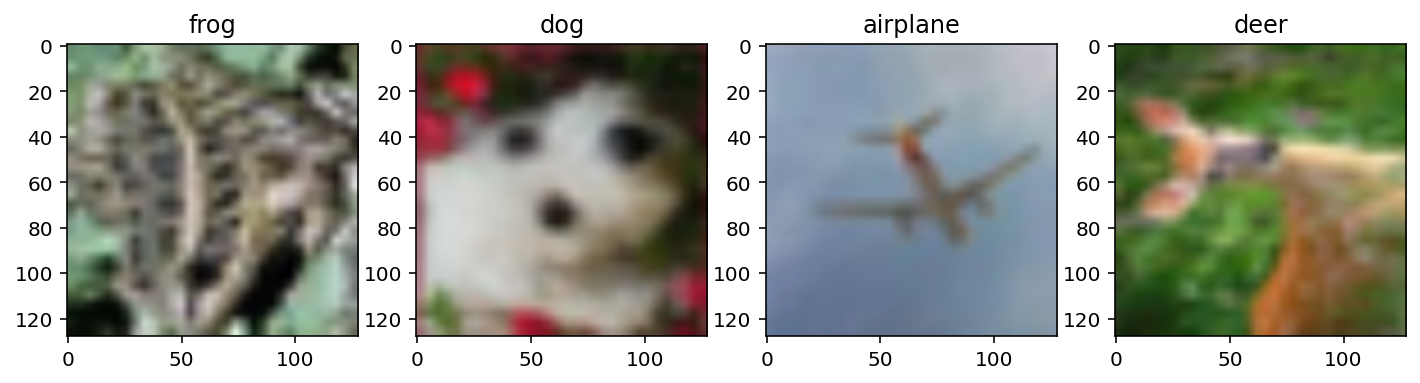

Class: ship, Shape: torch.Size([3, 256, 256])
Class: truck, Shape: torch.Size([3, 256, 256])
Class: horse, Shape: torch.Size([3, 256, 256])
Class: truck, Shape: torch.Size([3, 256, 256])


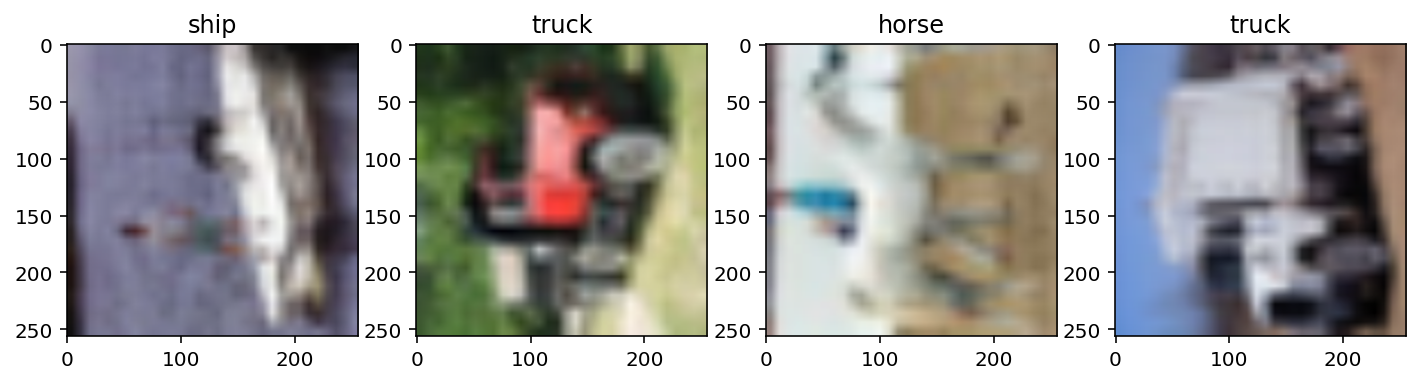

In [42]:
show4(loader_32['test'], label_mapping)
show4(loader_64['test'], label_mapping)
show4(loader_128['test'], label_mapping)
show4(loader_256['test'], label_mapping)

### Helper for building the network

In [43]:
def build_network(architecture, out_features, hidden_layers, label_mapping, log_model=False):

  model = getattr(torchvision.models, architecture)(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False

  # Find the number of in features the classifier expects
  try:
      iter(model.classifier)
  except TypeError:
      in_features = model.classifier.in_features
  else:
      in_features = model.classifier[0].in_features

  hidden = [in_features] + hidden_layers

  layers = []
  for i, (x, y) in enumerate(zip(hidden[:-1], hidden[1:])):
    layers.append((f'fc{i}', nn.Linear(x, y)))
    layers.append((f'relu{i}', nn.ReLU()))
    layers.append((f'dropout{i}', nn.Dropout(p=0.2)))
  layers.append(('fc_final', nn.Linear(hidden_layers[-1], out_features)))

  classifier = nn.Sequential(OrderedDict(layers))
  if log_model:
    print('Classifier:', classifier)

  classifier.out_features = out_features
  classifier.hidden_layers = hidden_layers
  classifier.label_mapping = label_mapping
  model.architecture = architecture
  
  model.classifier = classifier
  model.criterion = nn.CrossEntropyLoss()
  model.optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

  return model

### Helpers for saving and loading model

In [44]:
def save(model, filepath):
  checkpoint = {
    'out_features': model.classifier.out_features,
    'hidden_layers': model.classifier.hidden_layers,
    'architecture': model.architecture,
    'state_dict': model.state_dict(),
    'label_mapping': model.classifier.label_mapping,
  }
  torch.save(checkpoint, filepath)

def load(filepath):
  checkpoint = torch.load(filepath)
  model = build_network(checkpoint['architecture'],
                        checkpoint['out_features'],
                        checkpoint['hidden_layers'],
                        checkpoint['label_mapping'])
  model.load_state_dict(checkpoint['state_dict'])

  return model

### Helpers for training and testing models

In [45]:
def train(model, trainloader, valid_loader, path, epochs=1):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f'Training on device: {device}')

    start_time = time.time()
    train_losses, eval_losses = [], []
    train_accuracies, eval_accuracies = [], []
    best_eval_accuracy = 0

    for e in range(epochs):
        train_loss = []
        train_accuracy = []
        eval_loss = []
        eval_accuracy = []

        for images, labels in trainloader: 
            model.train()
            images, labels = images.to(device), labels.to(device)
            model.optimizer.zero_grad()
            logits = model.forward(images)
            loss = model.criterion(logits, labels)
            loss.backward()
            model.optimizer.step()

            train_loss.append(loss.item())
            ps = nn.Softmax(dim=1)(logits)
            _, top_class = ps.topk(1, dim=1)
            train_accuracy.append(torch.mean((top_class == labels.reshape(*top_class.shape)).type(torch.FloatTensor)).item())
            
        else:
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                with torch.no_grad():
                    model.eval()
                    logits = model.forward(images)
                    ps = nn.Softmax(dim=1)(logits)
                    eval_loss.append(model.criterion(logits, labels).item())
                    _, top_class = ps.topk(1, dim=1)
                    eval_accuracy.append(torch.mean((top_class == labels.reshape(*top_class.shape)).type(torch.FloatTensor)).item())
        
        train_loss = np.mean(train_loss)
        train_accuracy = np.mean(train_accuracy)
        eval_loss = np.mean(eval_loss)
        eval_accuracy = np.mean(eval_accuracy)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)

        interval_time = time.time()  
        print(f'--- Epoch {e + 1} --- Time elapsed: {int(interval_time - start_time)} seconds')
        print(f'train_accuracy: {round(train_accuracy*100, 2)}%    ', end=' ')
        print(f'train_loss:     {round(train_loss, 4)}')
        print(f'eval_accuracy:  {round(eval_accuracy*100, 2)}%  ', end=' ')
        print(f'eval_loss:      {round(eval_loss, 4)}')

        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
            print('Evaluation accuracy increased, Saving...')
            save(model, path)
    
    avg_time_per_epoch = int(interval_time - start_time) / epochs
    return (train_accuracies, eval_accuracies, train_losses, eval_losses, avg_time_per_epoch)

In [61]:
def test(model, testloader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  eval_accuracy = []
  eval_loss = []
  num_features = model.classifier.out_features
  confusion_matrix = np.zeros((num_features, num_features))

  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      model.eval()
      logits = model.forward(images)
      ps = nn.Softmax(dim=1)(logits)
      _, top_class = ps.topk(1, dim=1)
      eval_accuracy.append(torch.mean((top_class == labels.reshape(*top_class.shape)).type(torch.FloatTensor)).item())
      eval_loss.append(model.criterion(logits, labels).item())
      for prediction, target in zip(top_class, labels):
        confusion_matrix[target][prediction[0]] += 1

  eval_loss = np.mean(eval_loss)
  eval_accuracy = np.mean(eval_accuracy)
  
  print(f'Evaluation Loss:     {round(eval_loss, 4)}' )
  print(f'Evaluation Accuracy: {round(eval_accuracy * 100, 2)}%')
  
  print('Confusion Matrix:')
  cm = pd.DataFrame(confusion_matrix, label_mapping, label_mapping)
  fig, ax = plt.subplots(figsize=(8,6))
  sn.heatmap(cm, annot=True, fmt='g', ax=ax)
  plt.xlabel('Prediction')
  plt.ylabel('Target Class')
  plt.show()

  return eval_accuracy, eval_loss

In [ ]:
model_32 = build_network('vgg16', 10, [1000, 256, 64, 32], label_mapping)
stats_32 = train(model_32, loader_32['train'], loader_32['valid'], 'model_32.pth', epochs=15)

model trained with images resized to 32x32
Evaluation Loss:     1.1366
Evaluation Accuracy: 61.83%
Confusion Matrix:


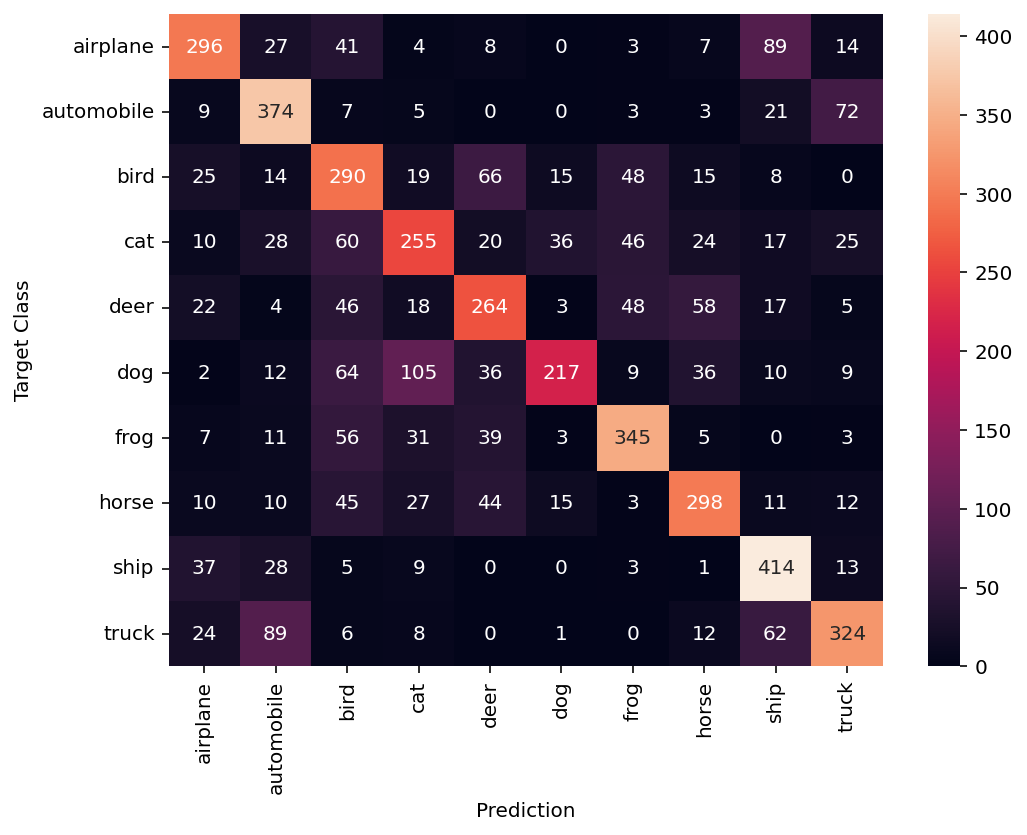

In [62]:
print('model trained with images resized to 32x32')
model_32 = load('model_32.pth')
accuracy_32, loss_32 = test(model_32, loader_32['test'])

In [ ]:
model_64 = build_network('vgg16', 10, [1000, 256, 64, 32], label_mapping)
stats_64 = train(model_64, loader_64['train'], loader_64['valid'], 'model_64.pth', epochs=15)

model trained with images resized to 64x64
Evaluation Loss:     0.6958
Evaluation Accuracy: 76.92%
Confusion Matrix:


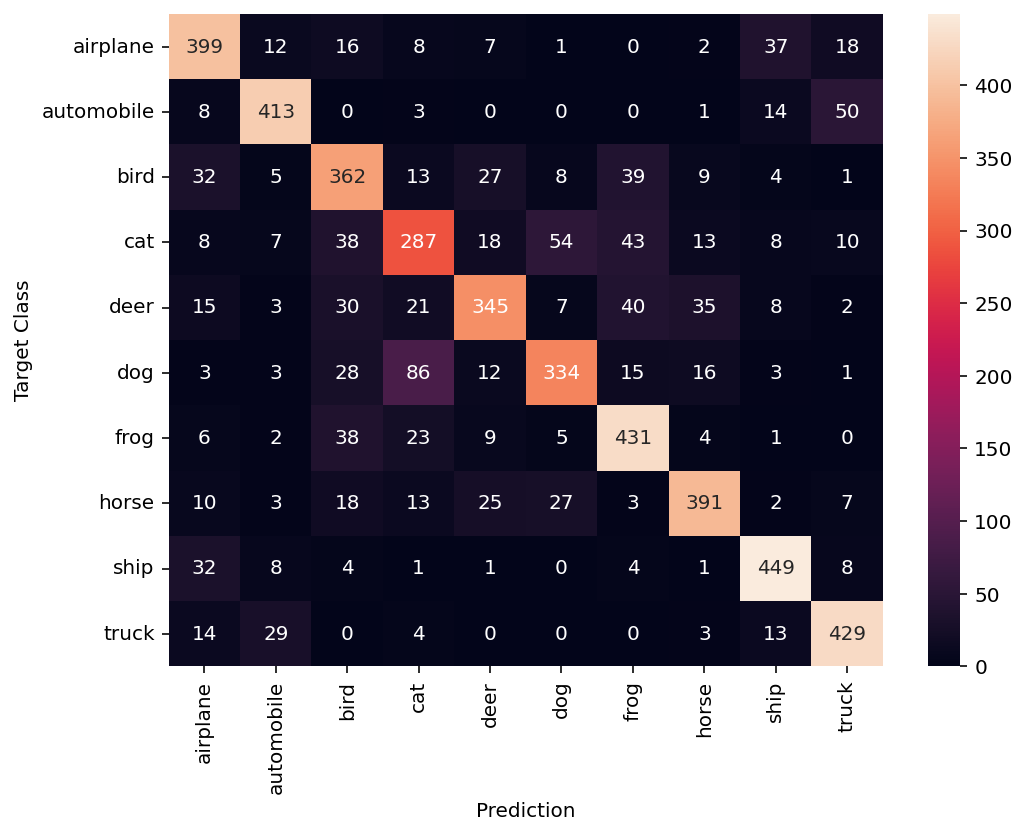

In [63]:
print('model trained with images resized to 64x64')
model_64 = load('model_64.pth')
accuracy_64, loss_64 = test(model_64, loader_64['test'])

In [ ]:
model_128 = build_network('vgg16', 10, [1000, 256, 64, 32], label_mapping,)
stats_128 = train(model_128, loader_128['train'], loader_128['valid'], 'model_128.pth', epochs=15)

model trained with images resized to 128x128
Evaluation Loss:     0.4375
Evaluation Accuracy: 85.28%
Confusion Matrix:


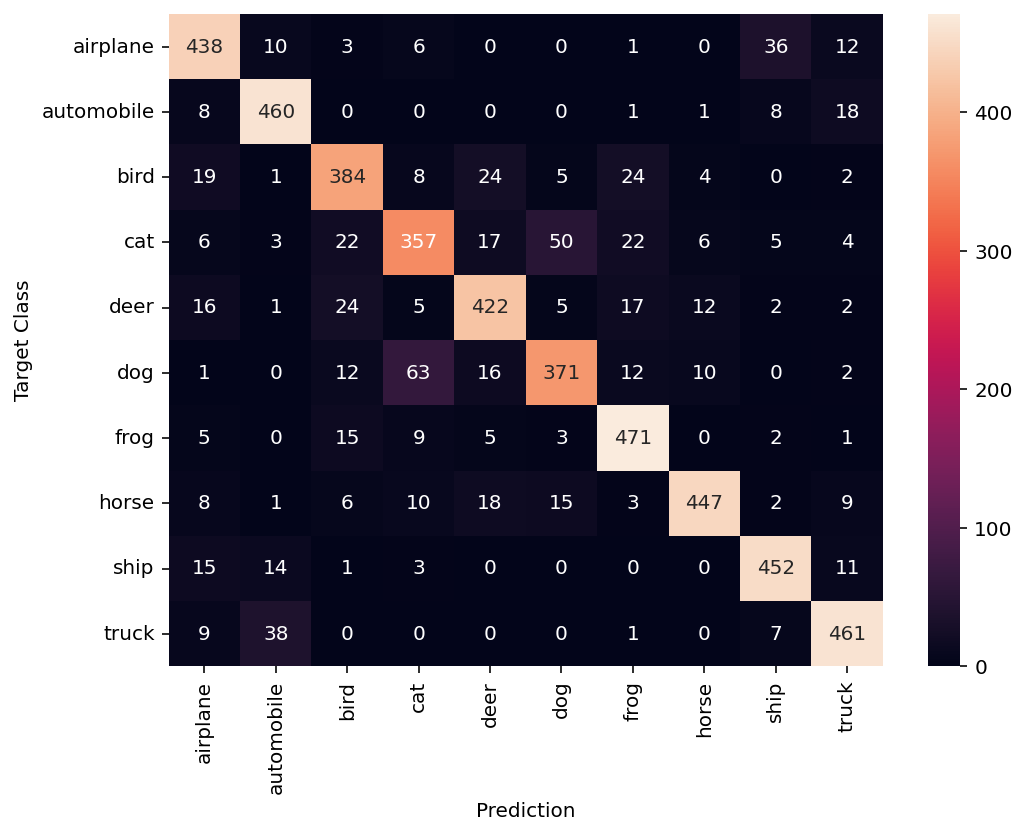

In [64]:
print('model trained with images resized to 128x128')
model_128 = load('model_128.pth')
accuracy_128, loss_128 = test(model_128, loader_128['test'])

In [ ]:
model_256 = build_network('vgg16', 10, [1000, 256, 64, 32], label_mapping,)
stats_256 = train(model_256, loader_256['train'], loader_256['valid'], 'model_256.pth', epochs=15)

model trained with images resized to 256x256
Evaluation Loss:     0.4685
Evaluation Accuracy: 84.63%
Confusion Matrix:


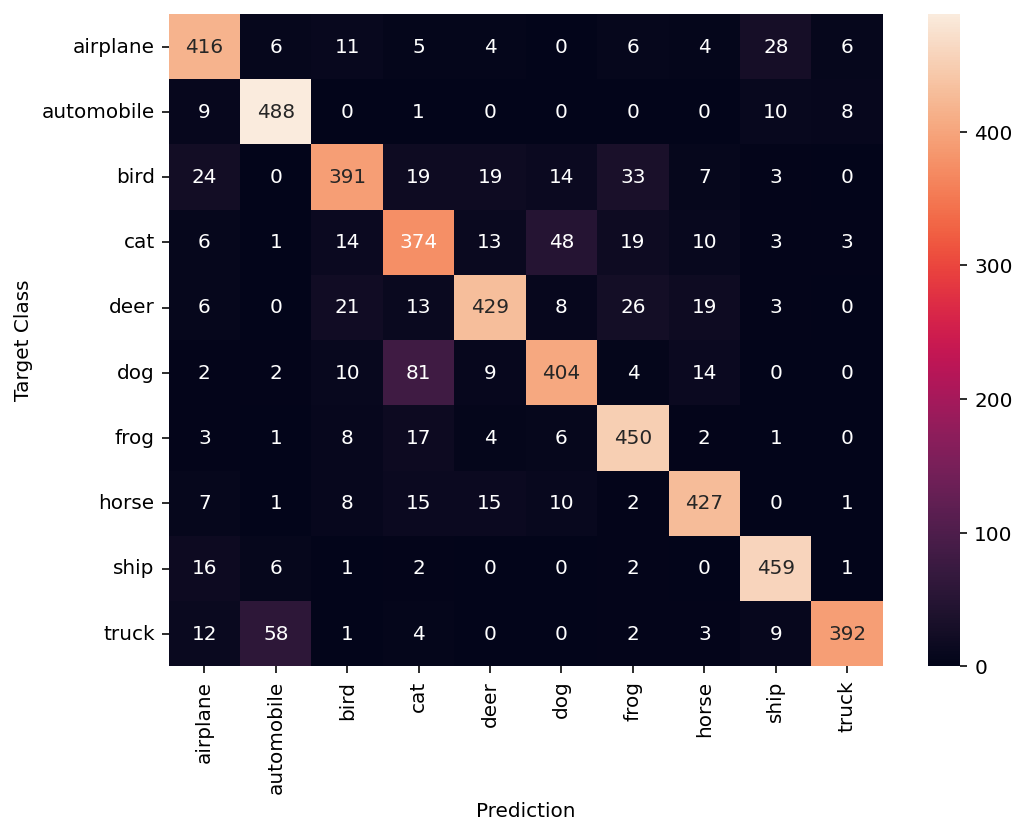

In [65]:
print('model trained with images resized to 256x256')
model_256 = load('model_256.pth')
accuracy_256, loss_256 = test(model_256, loader_256['test'])

In [67]:
img_sizes = [32, 64, 128, 256]
losses = [loss_32, loss_64, loss_128, loss_256]
accuracies = [accuracy_32, accuracy_64, accuracy_128, accuracy_256]
epoch_train_times = [stats_32[4], stats_64[4], stats_128[4], stats_256[4]]

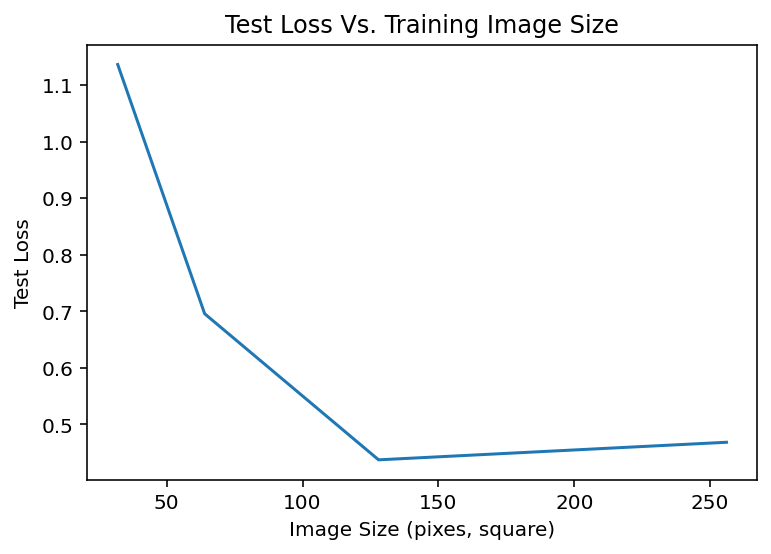

In [68]:
plt.plot(img_sizes, losses)
plt.title('Test Loss Vs. Training Image Size')
plt.xlabel('Image Size (pixes, square)')
plt.ylabel('Test Loss')
plt.show()

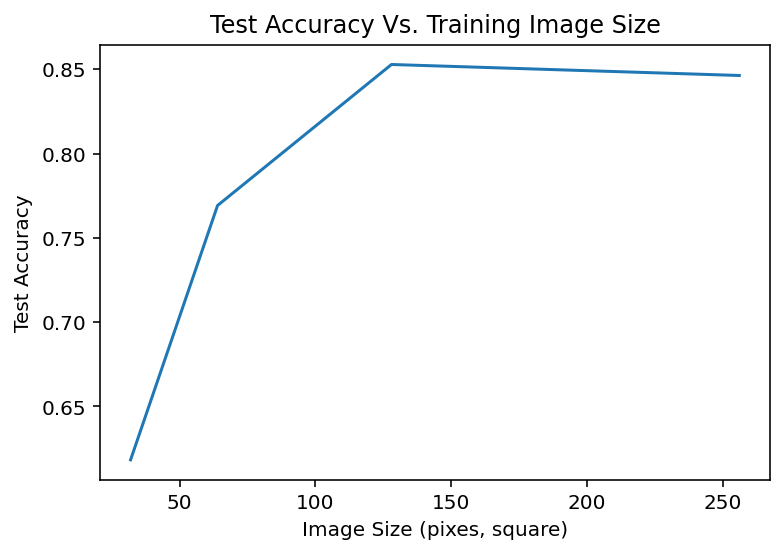

In [69]:
plt.plot(img_sizes, accuracies)
plt.title('Test Accuracy Vs. Training Image Size')
plt.xlabel('Image Size (pixes, square)')
plt.ylabel('Test Accuracy')
plt.show()

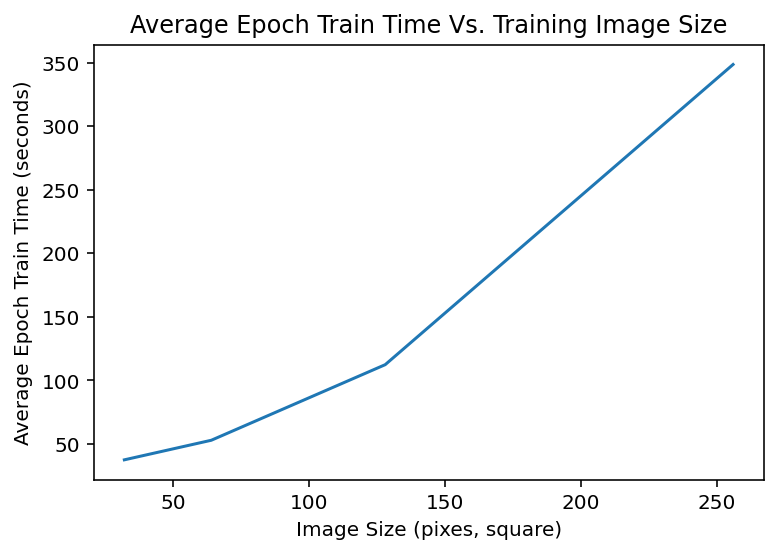

In [70]:
plt.plot(img_sizes, epoch_train_times)
plt.title('Average Epoch Train Time Vs. Training Image Size')
plt.xlabel('Image Size (pixes, square)')
plt.ylabel('Average Epoch Train Time (seconds)')
plt.show()

In [ ]:
def classify(model, image, label_idx):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  with torch.no_grad():
    model.eval()
    img_tensor = image.reshape(1, *image.shape).to(device)
    
    ps = nn.Softmax(dim=1)(model.forward(img_tensor))
    ps = ps.data.cpu().numpy().squeeze()
    
    image = image.numpy().T
    image = std * image + mean
    image = np.clip(image, 0, 1)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image)
    ax1.set_title(model.classifier.label_mapping[label_idx])
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(model.classifier.label_mapping, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

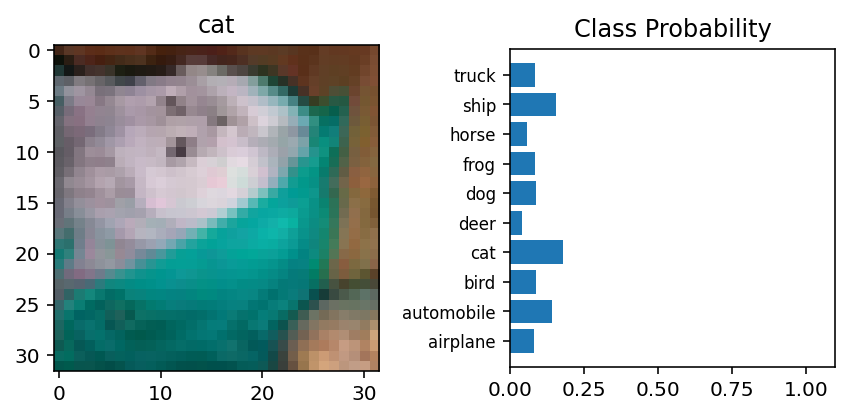

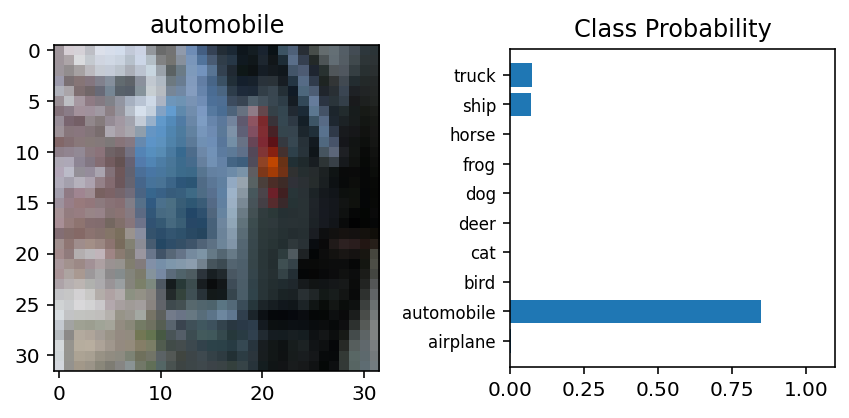

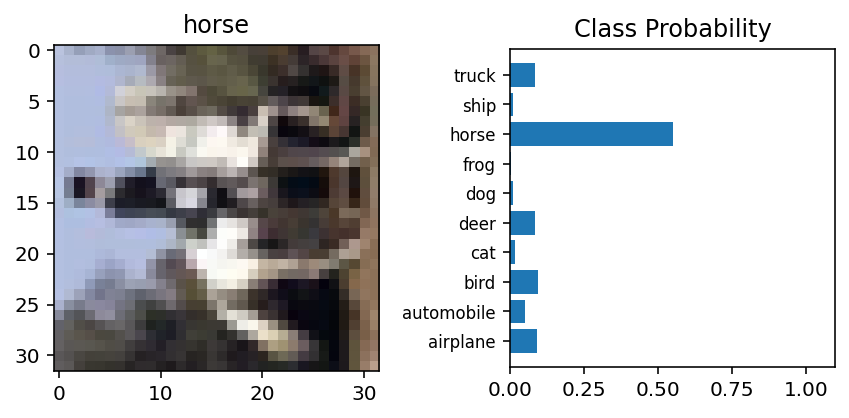

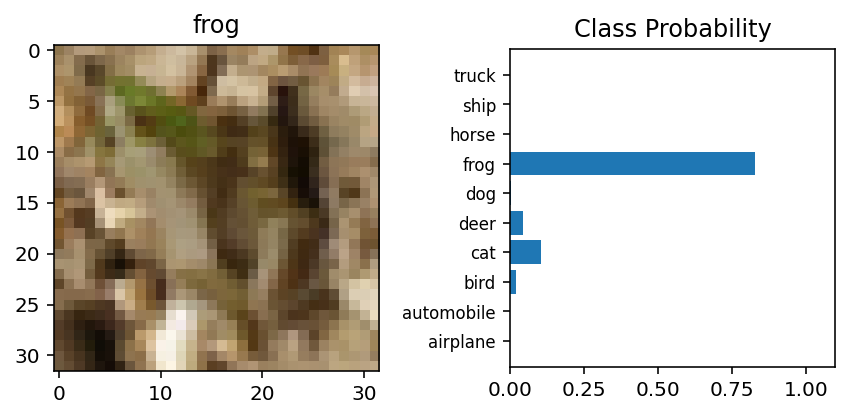

In [76]:
image, label = next(iter(loader_32['test']))
classify(model_32, image[0], label[0].item())
classify(model_32, image[1], label[1].item())
classify(model_32, image[2], label[2].item())
classify(model_32, image[3], label[3].item())

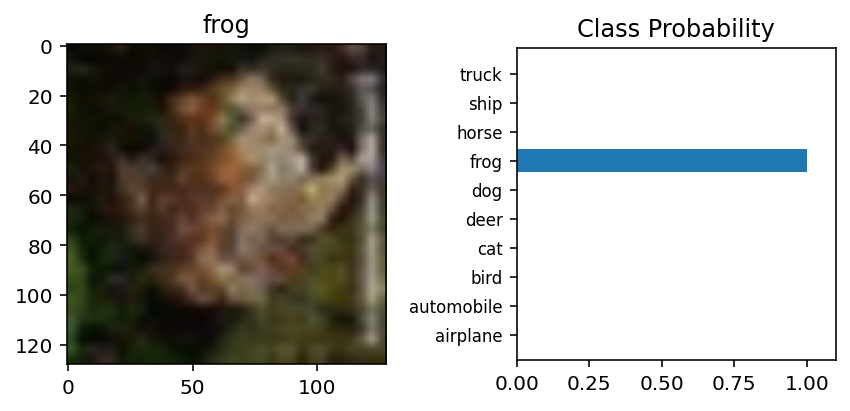

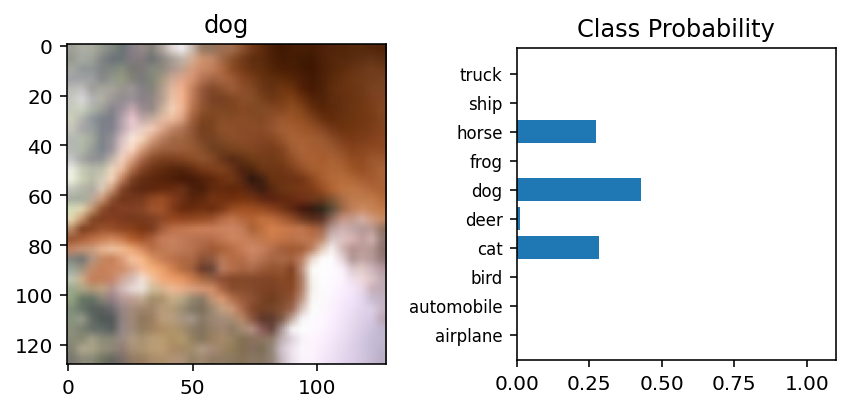

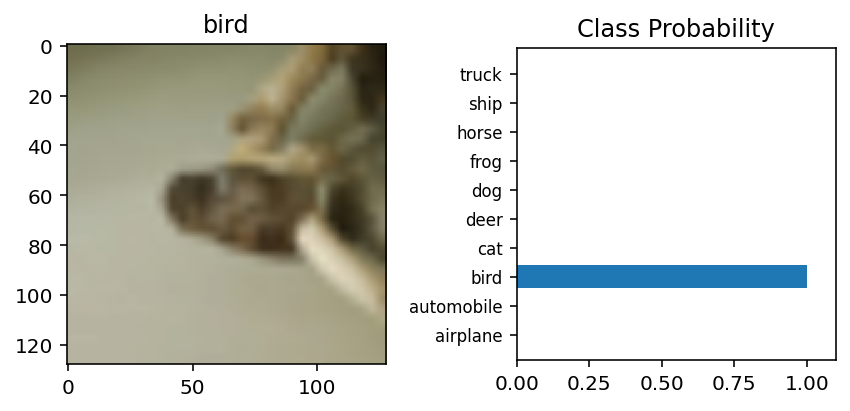

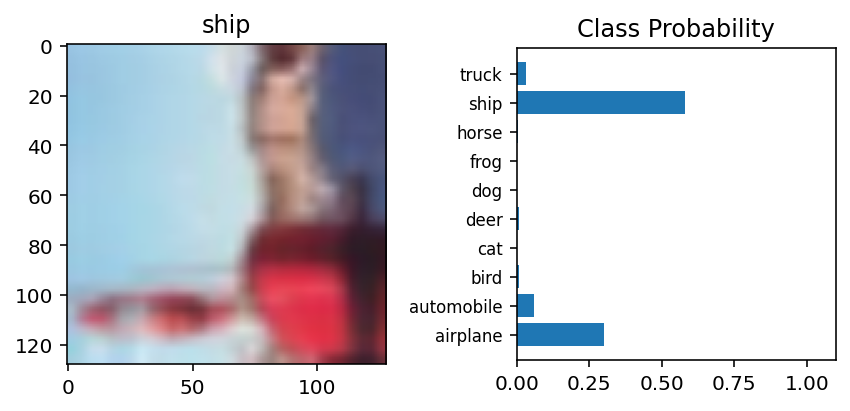

In [77]:
image, label = next(iter(loader_128['test']))
classify(model_128, image[0], label[0].item())
classify(model_128, image[1], label[1].item())
classify(model_128, image[2], label[2].item())
classify(model_128, image[3], label[3].item())